##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
orig_df = pd.read_csv('/content/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [3]:
df = pd.read_csv('/content/LVMPD-Stats.csv', parse_dates=['ReportedOn'], usecols = ['X','Y','ReportedOn', 'Area_Command','NIBRSOffenseCode', 'VictimCount'])
df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ] = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [4]:
df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [5]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [6]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?

##Ans
Range of values in each column:
* "X" (Latitude) and "Y" (Longitude) should represent geographical coordinates, and their values typically fall within certain ranges (e.g., latitude between -90 and 90 degrees, and longitude between -180 and 180 degrees).
* "Time" can range from 0 to 23, representing the hours of the day.
* "DayOfWeek" can range from 0 to 6, representing the days of the week (0 for Monday, 6 for Sunday).
* "Area_Command" and "NIBRSOffenseCode" are categorical variables and don't have a numeric range.
* "VictimCount" should be a non-negative integer, representing the number of persons involved in the incident.
Scaling, Shifting, or Normalizing the Data.
* For geographical coordinates "X" and "Y,"  Scaling or normalization might not be necessary for these columns as they might be in the defined range and also consistent
* For "Time" and "DayOfWeek," no additional scaling or normalization is needed since they are already within appropriate ranges.
* For "VictimCount," scaling and normalization might be required depending on the boundary values


In [7]:
print(df.head())

            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  


In [12]:
import pandas as pd


# Define the range for scaling (e.g., 0 to 1)
min_range = 0
max_range = 1

# Get the minimum and maximum values of 'VictimCount'
min_value = df['VictimCount'].min()
max_value = df['VictimCount'].max()

# Apply Min-Max scaling
df['NormalizedVictimCount'] = ((df['VictimCount'] - min_value) / (max_value - min_value)) * (max_range - min_range) + min_range



## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [13]:
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np

# Assuming 'df' contains your preprocessed data
X = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']]
Y = df['VictimCount']

# Convert input and target variables to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
Y_tensor = torch.tensor(Y.values, dtype=torch.float32)

# Convert tensors to NumPy arrays
X_array = X_tensor.numpy()
Y_array = Y_tensor.numpy()

# Split the data into training and testing sets
train_size = int(0.8 * len(X_array))
test_size = len(X_array) - train_size

X_train, X_test = X_array[:train_size], X_array[train_size:]
Y_train, Y_test = Y_array[:train_size], Y_array[train_size:]

# Define the dataset and DataLoader for training and testing
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the shape of data by iterating over one dataset (e.g., training set)
for inputs, targets in train_loader:
    print("Batch Shape - Inputs:", inputs.shape, "Targets:", targets.shape)
    break

Batch Shape - Inputs: torch.Size([64, 6]) Targets: torch.Size([64])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

#Solution
Let's go through your code and answer your questions step by step:

**Loss Function:**
 Mean Squared Error (MSE) loss,  is a suitable choice for a regression problem where we are predicting a real number (number of crime victims). MSE measures the average squared difference between predictions and the actual target values.

**Size of the Predicted Output:**
The size of the predicted output is 1, which is appropriate for regression tasks where you are predicting a single continuous value.

**Model Architecture I have use:**
I  have used a feedforward neural network with multiple hidden layers and ReLU activation functions. This architecture is suitable for regression problems. In this specific case, I have 3 hidden layers with 64 units each, followed by an output layer with 1 unit. The ReLU activation function is a common choice for hidden layers in neural networks.

**Optimizer and Learning Rate:**
You have chosen Stochastic Gradient Descent (SGD) as the optimizer with a learning rate of 0.001. The choice of the optimizer and learning rate depends on your specific problem and dataset. SGD is a good starting point, and the learning rate of 0.001 is reasonable for many tasks. However, the learning rate can be adjusted based on your observations during training.



**Model Training:**
I believe that my  model is training well, as the training loss is decreasing over time, indicating that the model is learning. To improve model accuracy, y I have adjuste the learning rate, hidden layer size,  and varied the number of layers.

In [9]:
import torch.nn as nn
# Define the neural network architecture
class CrimeVictimPredictor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CrimeVictimPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

# Define the loss function
loss_function = nn.MSELoss()

# Create the model
input_size = X_train.shape[1]
hidden_size = 64
model = CrimeVictimPredictor(input_size, hidden_size)

# Define the optimizer and learning rate
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = loss_function(predictions, targets.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Evaluation on the test data
model.eval()
test_loss = 0.0

with torch.no_grad():
    for inputs, targets in test_loader:
        predictions = model(inputs)
        test_loss += loss_function(predictions, targets.view(-1, 1)).item()

avg_test_loss = test_loss / len(test_loader)
print(f'Test MSE: {avg_test_loss:.4f}')

Epoch [1/100], Loss: 18.5308
Epoch [2/100], Loss: 0.9920
Epoch [3/100], Loss: 0.9293
Epoch [4/100], Loss: 0.8238
Epoch [5/100], Loss: 0.8433
Epoch [6/100], Loss: 0.8020
Epoch [7/100], Loss: 0.8047
Epoch [8/100], Loss: 0.8417
Epoch [9/100], Loss: 0.8470
Epoch [10/100], Loss: 0.8320
Epoch [11/100], Loss: 0.7862
Epoch [12/100], Loss: 0.8515
Epoch [13/100], Loss: 0.7712
Epoch [14/100], Loss: 0.8214
Epoch [15/100], Loss: 0.7515
Epoch [16/100], Loss: 0.7893
Epoch [17/100], Loss: 0.7831
Epoch [18/100], Loss: 0.8239
Epoch [19/100], Loss: 0.8551
Epoch [20/100], Loss: 0.7496
Epoch [21/100], Loss: 0.7685
Epoch [22/100], Loss: 0.8094
Epoch [23/100], Loss: 0.8231
Epoch [24/100], Loss: 0.7991
Epoch [25/100], Loss: 0.7975
Epoch [26/100], Loss: 0.8201
Epoch [27/100], Loss: 0.8522
Epoch [28/100], Loss: 0.7859
Epoch [29/100], Loss: 0.8506
Epoch [30/100], Loss: 0.7490
Epoch [31/100], Loss: 0.7682
Epoch [32/100], Loss: 0.8193
Epoch [33/100], Loss: 0.8123
Epoch [34/100], Loss: 0.8462
Epoch [35/100], Loss: 

## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

##Solution -
* Number of classes - To find the number of classes in the output data, I calculated the number of unique classes in your training labels (Y_train).
* Architecture Difference:
In a classification task, the output layer of your neural network should have a number of units equal to the number of classes (num_classes). The major difference in the architecture is the output layer. In my code, I have added an additional fully connected layer with num_classes units. This layer is responsible for producing class scores for each class. I have also one more layer compared to the regression task.




In [14]:
import torch.nn as nn

# Define the neural network architecture for classification
class CrimeVictimClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CrimeVictimClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        return x

# Define the model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = 64
num_classes = len(set(Y_train))  # Calculate the number of unique classes from the training data
model = CrimeVictimClassifier(input_size, hidden_size, num_classes)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0010)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    bst_acc = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        predictions = model(inputs)
        targets = targets.long()
        loss = loss_function(predictions, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(predictions.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    with torch.no_grad():
          for inputs, targets in test_loader:
              predictions = model(inputs)
              _, predicted = torch.max(predictions.data, 1)
              total += targets.size(0)
              correct += (predicted == targets).sum().item()
    test_accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}],  Accuracy: {test_accuracy:.2f}%')
    # Check if this model achieved the best accuracy
    if test_accuracy > bst_acc:
        best_accuracy = test_accuracy
        best_model = model
        best_hyperparameters = {
            'learning_rate': learning_rate,
            'hidden_size': hidden_size
        }
print("Best Test Accuracy:", best_accuracy)

Epoch [1/100],  Accuracy: 36.36%
Epoch [2/100],  Accuracy: 36.36%
Epoch [3/100],  Accuracy: 36.36%
Epoch [4/100],  Accuracy: 36.36%
Epoch [5/100],  Accuracy: 36.36%
Epoch [6/100],  Accuracy: 36.36%
Epoch [7/100],  Accuracy: 36.36%
Epoch [8/100],  Accuracy: 36.73%
Epoch [9/100],  Accuracy: 39.27%
Epoch [10/100],  Accuracy: 48.73%
Epoch [11/100],  Accuracy: 52.36%
Epoch [12/100],  Accuracy: 51.64%
Epoch [13/100],  Accuracy: 51.64%
Epoch [14/100],  Accuracy: 51.64%
Epoch [15/100],  Accuracy: 51.64%
Epoch [16/100],  Accuracy: 51.64%
Epoch [17/100],  Accuracy: 51.64%
Epoch [18/100],  Accuracy: 51.64%
Epoch [19/100],  Accuracy: 51.64%
Epoch [20/100],  Accuracy: 51.64%
Epoch [21/100],  Accuracy: 51.64%
Epoch [22/100],  Accuracy: 51.64%
Epoch [23/100],  Accuracy: 51.64%
Epoch [24/100],  Accuracy: 51.64%
Epoch [25/100],  Accuracy: 51.64%
Epoch [26/100],  Accuracy: 51.64%
Epoch [27/100],  Accuracy: 51.64%
Epoch [28/100],  Accuracy: 51.64%
Epoch [29/100],  Accuracy: 51.64%
Epoch [30/100],  Accura

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

#Solution -
In tasks 3 and 4, the transition from a regression problem to a classification problem significantly altered the approach and the neural network architecture. In task 3, the objective was to predict the number of crime victims as a real number, which required a regression model, while in task 4, the goal shifted to predicting the number of crime victims as a class number, turning it into a classification problem. The architecture, loss function, and evaluation metrics were adapted accordingly. In task 4, the classification model, employing a Cross-Entropy Loss and outputting class probabilities, aimed to categorize the data into discrete classes. Comparing the results, the success of one over the other largely depends on the nature of the problem. For regression, the MSE loss measured the closeness of predictions to actual values, while for classification, the accuracy and Cross-Entropy Loss were key metrics. The performance of one approach over the other is not directly comparable, as they serve different problem domains. The choice between regression and classification depends on the specific task and the nature of the datawhether the target variable should be predicted as a continuous value or assigned to a discrete class.

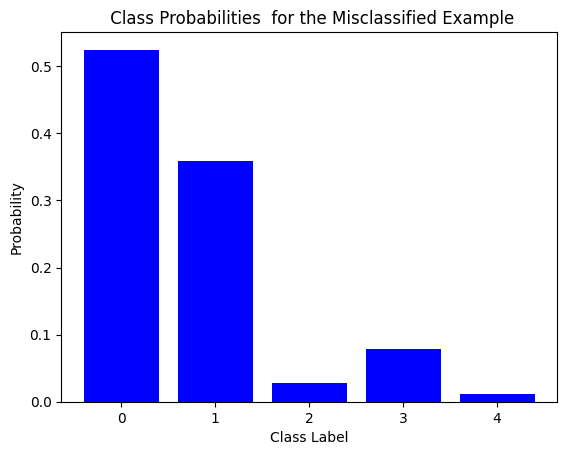

Correct Class Label: 2.0


In [23]:
import torch
import matplotlib.pyplot as plt


misclassified_examples = []
misclassified_labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)

        # Finding the  misclassified examples
        misclassified_mask = predicted != targets
        misclassified_examples.extend(inputs[misclassified_mask])
        misclassified_labels.extend(targets[misclassified_mask])

import random
random_index = random.randint(0, len(misclassified_examples) - 1)
misclassified_example = misclassified_examples[random_index]
correct_label = misclassified_labels[random_index].item()


with torch.no_grad():
    misclassified_example = misclassified_example.unsqueeze(0)
    outputs = model(misclassified_example)
    class_probabilities = torch.softmax(outputs, dim=1).numpy()[0]


class_labels = [str(i) for i in range(len(class_probabilities))]
plt.bar(class_labels, class_probabilities, color='blue')
plt.xlabel('Class Label')
plt.ylabel('Probability')
plt.title(' Class Probabilities  for the Misclassified Example')
plt.show()

print(f"Correct Class Label: {correct_label}")

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


#Solution
Pattern -
1 st graph - the cluster indicates that the crime is prone to happen between thursday and friday.
2nd graph - the   cluster of dark-colored points,  implies that this area is more prone to incidents involving a larger number of people.

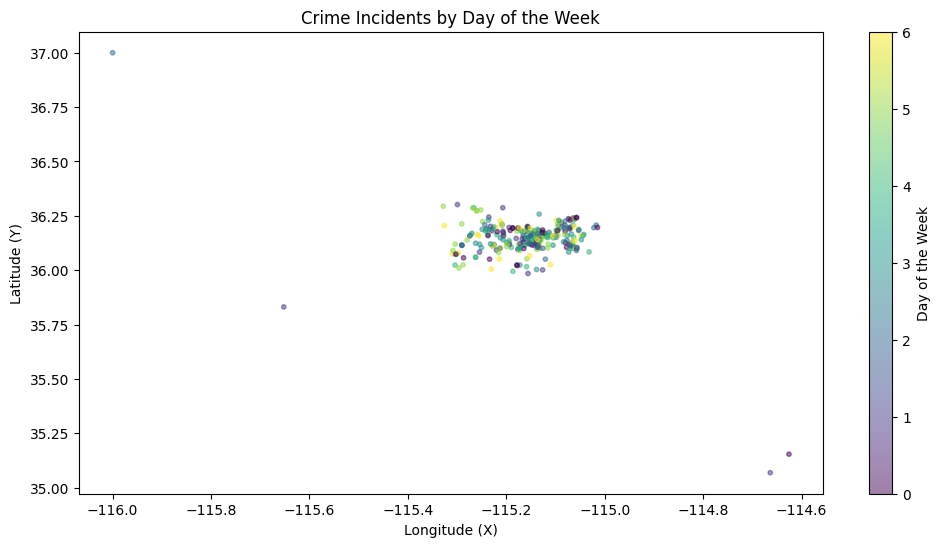

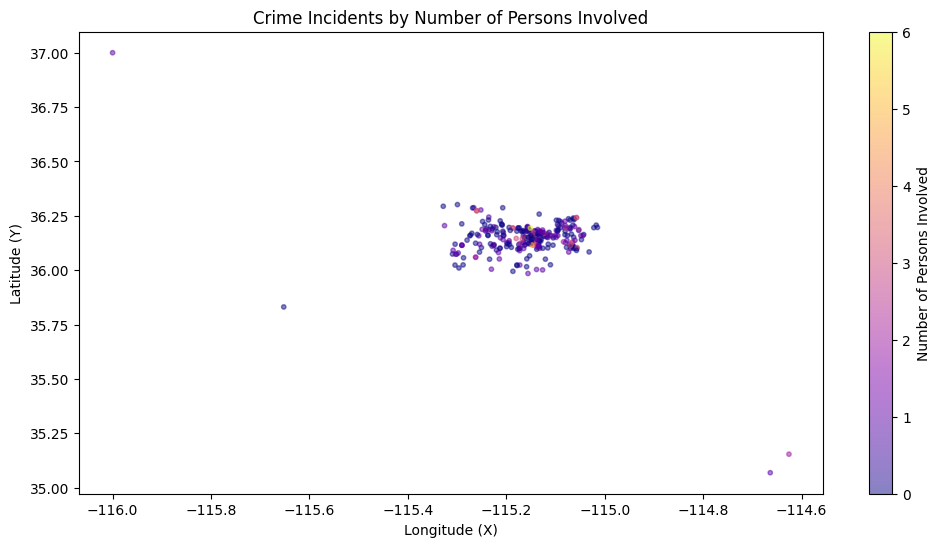

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot with color indicating the day of the week
plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis', s=10, alpha=0.5)
plt.colorbar(label='Day of the Week')
plt.title('Crime Incidents by Day of the Week')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.show()

# Scatter plot with color indicating the number of persons involved
plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='plasma', s=10, alpha=0.5)
plt.colorbar(label='Number of Persons Involved')
plt.title('Crime Incidents by Number of Persons Involved')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.show()

In [17]:
# Sort the number of crimes reported by the day of the week
day_of_week_counts = df['DayOfWeek'].value_counts().sort_index()
# Print the most frequent days
print("Most frequent days:")
print(day_of_week_counts)

Most frequent days:
0    40
1    37
2    32
3    44
4    51
5    43
6    28
Name: DayOfWeek, dtype: int64
